# OxCOVID19 (https://covid19.eng.ox.ac.uk/) - Confirmed cases for China


This notebook demonstrates how to connect to COVID19db Postgres database and how to generate country level visualisaion.

In [24]:
import psycopg2
import pandas as pd
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()
import matplotlib.pyplot as plt

# Connect to covid19db.org
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19_test',
    user='covid19',
    password='covid19'
)
cur = conn.cursor()

# Retrieving epidemiology data for single source 

In [25]:
# Load all data for region 1
sql_command = """SELECT * FROM epidemiology WHERE source = %(source)s AND adm_area_1 <> '' ORDER by date DESC"""
df = pd.read_sql(sql_command, conn, params={'source': 'CHN_ICL'})
df.head()

,source,date,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,hospitalised,hospitalised_icu,quarantined,gid
0,CHN_ICL,2020-04-01,China,CHN,Shanxi,None,None,None,137.0,133.0,NaN,None,None,None,[CHN.25_1]
1,CHN_ICL,2020-04-01,China,CHN,Beijing,None,None,None,580.0,418.0,8.0,None,None,None,[CHN.2_1]
2,CHN_ICL,2020-03-31,China,CHN,Zhejiang,None,None,None,1257.0,1226.0,1.0,None,None,None,[CHN.31_1]
3,CHN_ICL,2020-03-31,China,CHN,Xizang,None,None,None,1.0,1.0,0.0,None,None,None,[CHN.29_1]
4,CHN_ICL,2020-03-31,China,CHN,Xinjiang Uygur,None,None,None,76.0,73.0,3.0,None,None,None,[CHN.28_1]


# Extracting only recent data - total per region

In [26]:
df_recent = df.copy()
df_recent['gid'] = [','.join(map(str, l)) for l in df['gid']]
df_recent = df_recent.sort_values('date').groupby('adm_area_1').apply(lambda x: x.max())

df_recent = df_recent.set_index('date')
df_recent[["country", "adm_area_1", "confirmed", "recovered", "dead", "gid"]].head(30)

,country,adm_area_1,confirmed,recovered,dead,gid
date,,,,,,
2020-03-31,China,Anhui,990.0,984.0,6.0,CHN.1_1
2020-04-01,China,Beijing,580.0,418.0,8.0,CHN.2_1
2020-03-31,China,Chongqing,579.0,570.0,6.0,CHN.3_1
2020-03-30,China,Fujian,343.0,295.0,1.0,CHN.4_1
2020-03-31,China,Gansu,137.0,127.0,2.0,CHN.5_1
2020-03-31,China,Guangdong,1501.0,1357.0,8.0,CHN.6_1
2020-03-31,China,Guangxi,255.0,250.0,2.0,CHN.7_1
2020-03-31,China,Guizhou,147.0,144.0,2.0,CHN.8_1
2020-03-30,China,Hainan,168.0,162.0,6.0,CHN.9_1


### Retrieving administrative division level 1 for single country from covid19db

In [27]:
# Get Covid19db administrative division
import geopandas as gpd
def get_administrative_division(level=0, countrycode=None):
    sql = f"SELECT * FROM administrative_division WHERE adm_level={level} "
    if level>0 and countrycode: 
        sql = sql +  f"AND countrycode='{countrycode}'"

    admin_data = gpd.GeoDataFrame.from_postgis(sql, conn, geom_col='geometry')
    admin_data["area"] = admin_data['geometry'].area
    return admin_data

In [28]:
admin_1_data = get_administrative_division(level=1, countrycode='CHN')
admin_1_data.head()

,country,countrycode,countrycode_alpha2,adm_level,adm_area_1,adm_area_1_code,adm_area_2,adm_area_2_code,adm_area_3,adm_area_3_code,gid,latitude,longitude,properties,geometry,area
0,China,CHN,CN,1,Guizhou,CHN.8_1,None,None,None,None,CHN.8_1,26.815182,106.874099,"{'CC_1': None, 'GID_0': 'CHN', 'GID_1': 'CHN.8...","MULTIPOLYGON (((109.55132 26.72297, 109.53745 ...",15.980733
1,China,CHN,CN,1,Anhui,CHN.1_1,None,None,None,None,CHN.1_1,31.825786,117.226230,"{'CC_1': None, 'GID_0': 'CHN', 'GID_1': 'CHN.1...","POLYGON ((116.58147 30.04759, 116.53297 29.900...",13.370060
2,China,CHN,CN,1,Beijing,CHN.2_1,None,None,None,None,CHN.2_1,40.184914,116.410671,"{'CC_1': None, 'GID_0': 'CHN', 'GID_1': 'CHN.2...","POLYGON ((116.23775 39.51794, 116.23487 39.550...",1.733447
3,China,CHN,CN,1,Chongqing,CHN.3_1,None,None,None,None,CHN.3_1,30.058649,107.874840,"{'CC_1': None, 'GID_0': 'CHN', 'GID_1': 'CHN.3...","POLYGON ((109.23199 28.87890, 109.23772 28.780...",7.710093
4,China,CHN,CN,1,Fujian,CHN.4_1,None,None,None,None,CHN.4_1,26.081057,117.989944,"{'CC_1': None, 'GID_0': 'CHN', 'GID_1': 'CHN.4...","MULTIPOLYGON (((120.71680 26.99545, 120.71736 ...",11.012917


# Merge administrative division and epidemiology data


In [29]:
data_pd = df_recent.merge(admin_1_data, how = 'outer', left_on = 'gid', right_on = 'gid', suffixes=('', '_y'))
data_pd = gpd.GeoDataFrame(data_pd, geometry='geometry')
data_pd.head()

,source,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,...,adm_area_1_code,adm_area_2_y,adm_area_2_code,adm_area_3_y,adm_area_3_code,latitude,longitude,properties,geometry,area
0,CHN_ICL,China,CHN,Anhui,None,None,None,990.0,984.0,6.0,...,CHN.1_1,None,None,None,None,31.825786,117.226230,"{'CC_1': None, 'GID_0': 'CHN', 'GID_1': 'CHN.1...","POLYGON ((116.58147 30.04759, 116.53297 29.900...",13.370060
1,CHN_ICL,China,CHN,Beijing,None,None,None,580.0,418.0,8.0,...,CHN.2_1,None,None,None,None,40.184914,116.410671,"{'CC_1': None, 'GID_0': 'CHN', 'GID_1': 'CHN.2...","POLYGON ((116.23775 39.51794, 116.23487 39.550...",1.733447
2,CHN_ICL,China,CHN,Chongqing,None,None,None,579.0,570.0,6.0,...,CHN.3_1,None,None,None,None,30.058649,107.874840,"{'CC_1': None, 'GID_0': 'CHN', 'GID_1': 'CHN.3...","POLYGON ((109.23199 28.87890, 109.23772 28.780...",7.710093
3,CHN_ICL,China,CHN,Fujian,None,None,None,343.0,295.0,1.0,...,CHN.4_1,None,None,None,None,26.081057,117.989944,"{'CC_1': None, 'GID_0': 'CHN', 'GID_1': 'CHN.4...","MULTIPOLYGON (((120.71680 26.99545, 120.71736 ...",11.012917
4,CHN_ICL,China,CHN,Gansu,None,None,None,137.0,127.0,2.0,...,CHN.5_1,None,None,None,None,37.820789,100.933874,"{'CC_1': None, 'GID_0': 'CHN', 'GID_1': 'CHN.5...","POLYGON ((101.77423 33.54804, 101.73432 33.502...",41.507298


# TEST 1: Checking unmatched regions

### Result should be empty - if not try to correct your fetcher, probably there is a mismatch in adm_areas

In [30]:
# If this is not empty region matching has to be corrected !!!!!
unmatched_regions = data_pd[(data_pd.geometry.isna() | data_pd.countrycode.isna() | data_pd.countrycode_y.isna())]
unmatched_regions

,source,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,...,adm_area_1_code,adm_area_2_y,adm_area_2_code,adm_area_3_y,adm_area_3_code,latitude,longitude,properties,geometry,area


# Plotting functions

In [31]:
from termcolor import colored
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import geoplot as gplt

def choropleth_administrative_division(data, hue, label=None, cmap='Reds', k=10, add_text=False):
    schema = mc.Quantiles(data[hue], k=k) 
    gplt.choropleth(
        data,     
        hue=hue,     
        edgecolor='white', 
        linewidth=1,
        cmap=cmap,
        scheme=schema,
        legend=True, 
        legend_kwargs={'bbox_to_anchor': (1, 0.9), 'frameon': False},
    )
    if add_text:
        label = label or hue
        for _, row in data.iterrows():
          plt.text(s=row[label], x = row['longitude'], y = row['latitude'],
                   horizontalalignment='center', 
                   fontdict = {'weight': 'bold', 'size': 10, 'family': 'serif', 'color':  'darkgray',})
        
        
def plot_time_series(data, col):
    for key, grp in df.groupby(['adm_area_1']): 
        grp = grp[grp[col].notna()] # Drop NA
        plt.plot(grp.date, grp[col], '-o', linewidth=4.0, label=key)
        if not grp[col].is_monotonic_decreasing:
            print(colored(f'Series in not monotonic increasing: {key}', 'red'))
            print(grp[['date', col]])

    plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5)) 
    plt.grid()
    plt.title(f'{col} cases per adm_area_1');
    plt.show()

# TEST 2: Regions matching test - check if data is matched correctly with regions

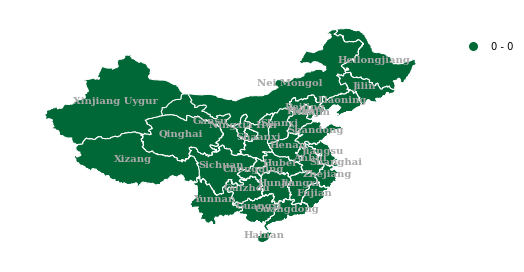

In [33]:
def check(x):
    if pd.isnull(x['countrycode']) or pd.isnull(x['countrycode_y']):
        return 1
    return 0
    
data_pd['errors'] = data_pd.apply(lambda x: check(x), axis=1)
choropleth_administrative_division(data_pd, 'errors', 
                                   label='adm_area_1', 
                                   cmap='RdYlGn_r', 
                                   add_text=True,
                                   k=len(data_pd.errors.unique()))

# Red - problem (incorrect matching, data missing)
# Green - OK

# Plot epidemiology total confirmed


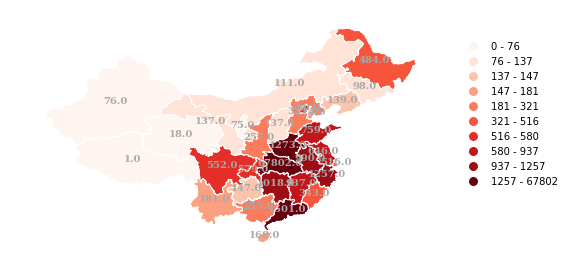

In [35]:
data_pd['confirmed'].fillna(0, inplace = True)
choropleth_administrative_division(data_pd, 'confirmed', add_text=True)

# Plot epidemiology total deaths

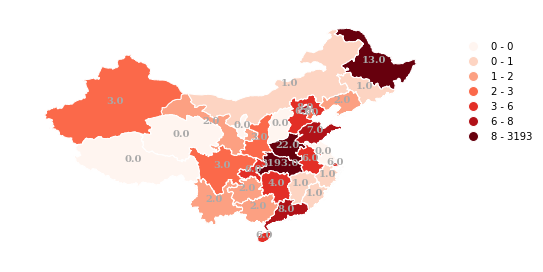

In [37]:
data_pd['dead'].fillna(0, inplace = True)
choropleth_administrative_division(data_pd, 'dead', add_text=True)

# TEST 3: checking the monotonicity of data - confirmed

Series in not monotonic increasing: Liaoning
            date  confirmed
41    2020-03-30      139.0
72    2020-03-29      136.0
103   2020-03-28      134.0
134   2020-03-27      131.0
165   2020-03-26      128.0
...          ...        ...
2002  2020-01-26       22.0
2031  2020-01-25       19.0
2056  2020-01-24       12.0
2081  2020-01-23        4.0
2102  2020-01-22        2.0

[69 rows x 2 columns]
Series in not monotonic increasing: Shaanxi
            date  confirmed
10    2020-03-31      257.0
37    2020-03-30      255.0
68    2020-03-29      255.0
99    2020-03-28      255.0
130   2020-03-27      255.0
...          ...        ...
1998  2020-01-26       35.0
2027  2020-01-25       22.0
2054  2020-01-24       15.0
2079  2020-01-23        5.0
2101  2020-01-22        3.0

[70 rows x 2 columns]
Series in not monotonic increasing: Yunnan
            date  confirmed
29    2020-03-30      181.0
60    2020-03-29      180.0
91    2020-03-28      180.0
122   2020-03-27      180.0
153   2020

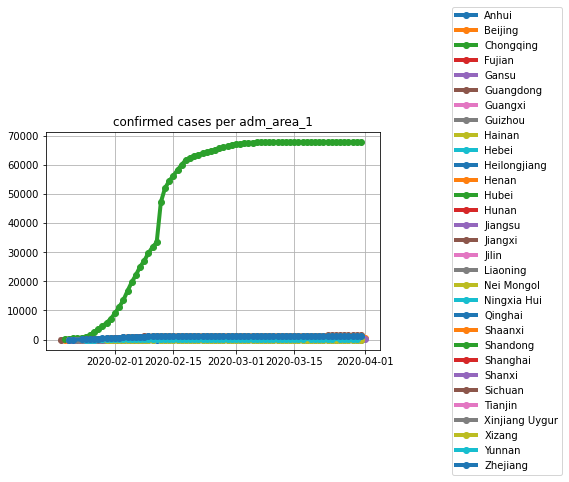

In [38]:
plot_time_series(df, 'confirmed')

# TEST 4: checking the monotonicity of data - dead

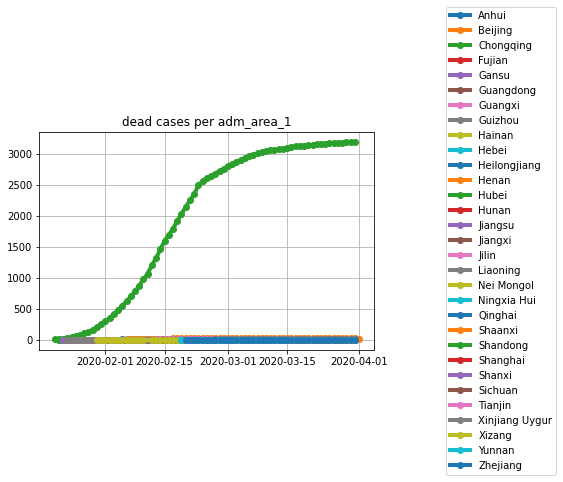

In [39]:
plot_time_series(df, 'dead')